## M2 - Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *
from C05_model_evaluate import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Data Collections

In [3]:
# load dataset
dataset = data_hotspot("dataset_enso.csv")
print(dataset.tail(3))

      acq_date  hotspot  sst_anom  oni_anom  soi_anom
273 2023-10-31     3200      1.59      1.78      -0.8
274 2023-11-30      390      1.90      1.92      -1.3
275 2023-12-31       42      1.99      1.97      -0.4


### 2. Data Preprocessing

In [4]:
# prosess normalization min-max
scaler, scaled = normalized(dataset, ["hotspot", "sst_anom", "oni_anom", "soi_anom"])

In [5]:
# hasil normalisasi data
np.round(scaled[:3],5)

array([[-1.     , -0.61485, -0.5514 ,  0.36   ],
       [-0.99972, -0.52204, -0.47664,  0.6    ],
       [-0.99903, -0.43387, -0.43925,  0.34   ]])

### 3. Pembagian Data

In [6]:
# proses pembagian data
x_train, y_train, x_test, y_test = results_multivariate_supervised(scaled)

In [7]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(216, 1, 4) (216,)


In [8]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 4) (59,)


### 4. Algoritma LSTM-RNN

In [9]:
# call models LSTM
# param : algorithm, timestep, activation, optimizer, dropout
lstm_model = get_models(
  algorithm="SBi-LSTM", timestep=x_train, activation="elu", optimizer="adam", dropout=0.20
)

In [10]:
# compile models
# param : model, batch_size, epochs, x_train, y_train, x_test, y_test
lstm_history, lstm_predictions = get_prediction(
  model=lstm_model, batch_size=32, epochs=1500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

Epoch 1/1500
7/7 [==============================] - 11s 229ms/step - loss: 0.9179 - mean_absolute_error: 0.9179 - mean_squared_error: 0.8667 - mean_absolute_percentage_error: 98.9243 - val_loss: 0.9324 - val_mean_absolute_error: 0.9324 - val_mean_squared_error: 0.8843 - val_mean_absolute_percentage_error: 97.4607
Epoch 2/1500
7/7 [==============================] - 0s 9ms/step - loss: 0.8974 - mean_absolute_error: 0.8974 - mean_squared_error: 0.8289 - mean_absolute_percentage_error: 96.8110 - val_loss: 0.9104 - val_mean_absolute_error: 0.9104 - val_mean_squared_error: 0.8436 - val_mean_absolute_percentage_error: 95.1026
Epoch 3/1500
7/7 [==============================] - 0s 9ms/step - loss: 0.8749 - mean_absolute_error: 0.8749 - mean_squared_error: 0.7886 - mean_absolute_percentage_error: 94.4322 - val_loss: 0.8862 - val_mean_absolute_error: 0.8862 - val_mean_squared_error: 0.7998 - val_mean_absolute_percentage_error: 92.5052
Epoch 4/1500
7/7 [==============================] - 0s 9ms/st

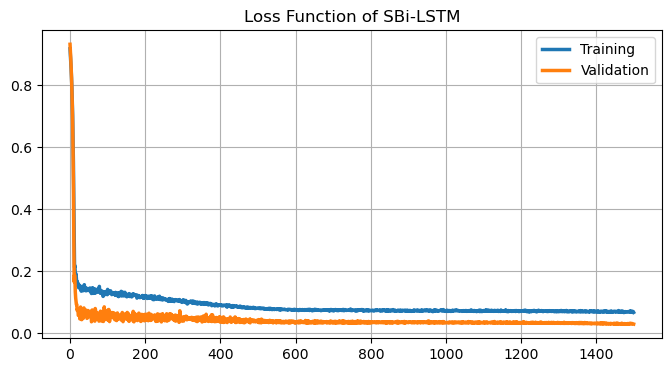

In [11]:
# show loss function
lineplot2(
  x1=lstm_history.epoch, y1=lstm_history.history['loss'], label1="Training",
  x2=lstm_history.epoch, y2=lstm_history.history['val_loss'], label2="Validation",
  title="Loss Function of SBi-LSTM"
)

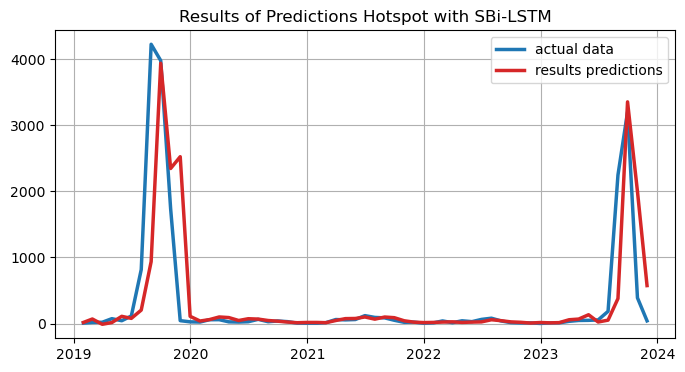

In [12]:
# show result predictions
scaler,_ = normalized(dataset, ["hotspot"])
lineplot3(
  x1=dataset["acq_date"].iloc[216:-1], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[216:-1], y2=inverse(scaler, lstm_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [13]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=y_test,
  ypred=lstm_predictions,
)

# results evaluate models
print("Evaluate Models with SBi-LSTM")
print("-----------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with SBi-LSTM
-----------------------------
R       : 0.7206
P-value : 0.0
MAE     : 0.0292
RMSE    : 0.0886
MAPE    : 0.0434


In [14]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, lstm_predictions.reshape(-1,1)),
)

# results evaluate models
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape*100))

R       : 0.7206
P-value : 0.0
MAE     : 210.6773
RMSE    : 639.6102
MAPE    : 199.72


In [15]:
# np.array(inverse(scaler, lstm_predictions)).reshape(-1)

pd.DataFrame(inverse(scaler,lstm_predictions))

,0
0,18.037338
1,69.981689
2,-9.670991
3,16.223324
4,110.445755
5,79.616997
6,204.977890
7,937.251526
8,3935.510986
9,2345.670654
